# Abstract

In this project, my aim was to practice my PyTorch and problem-solving skills by focusing on an image classification task that involves gender classification. To achieve this, I undertook the following tasks:

1. Load data
2. Data augmentation
3. Define multiple pretrained models
4. Create model architecture using 3 methods
5. Define functions to be used in training the model:
   - `label_optimizer(opt)`: Returns a string containing the name of the used optimizer.
   - `checkpoint_accuracy(accuracy_value, list_accuracy, path)`: Saves the weights of the best accuracy achieved during model training.
   - `checkpoint_loss(loss_value, list_loss, path)`: Saves the weights of the best loss achieved during model training.

6. Create verbosity to display progress during each iteration and epoch:
   - Display epochs
   - Display training accuracy and training loss for each iteration
   - Display validation accuracy and validation loss after each epoch.

7. Train the model and automate hyperparameter tuning.

8. Implement learning rate reduction and checkpoints.

9. Save the history of model training and the final weights for each set of hyperparameters.

10. Compare the training and validation results across all hyperparameters.


# Download Data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle_1.json ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle_1.json

chmod: cannot access '/root/.kaggle/kaggle_1.json': No such file or directory


In [ ]:
! kaggle datasets download -d cashutosh/gender-classification-dataset

100% 269M/269M [00:13<00:00, 23.2MB/s]
100% 269M/269M [00:13<00:00, 20.5MB/s]


In [ ]:
!unzip gender-classification-dataset

# Libraries

In [ ]:

import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam, RMSprop, SGD
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torchvision
import pathlib
from torchvision import models
from tqdm import tqdm
import time
import sys
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Input variables

In [ ]:
image_size=(48,48)                     #Image size
train_path="/content/Training"
val_path='/content/Validation'
path_test='/content/Dataset/Test'
model_name="vgg16"                     #Used pretrained model
batch_size=256                         #Batch size
num_classes=2                          #number of classes
num_neurons1=512                       #number of neurons in the first layer
num_neurons2=128                       #number of neurons in the second layer
Dropout1=0.5                           #Dropout associated to the first layer
Dropout2=0.5                           #Dropout associated to the second layer
num_epochs=5                              #Number of epochs to train the model

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load Data

In [ ]:
mean=[0.485, 0.456, 0.406]              #ImageNet
std=[0.229, 0.224, 0.225]               #ImageNet

In [ ]:
#Transforms
Transformer=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean,std)

])


In [ ]:
from torch.nn.modules import transformer

train_dataset=torchvision.datasets.ImageFolder(train_path,transform=Transformer)
validation_dataset=torchvision.datasets.ImageFolder(val_path,Transformer)
#DataLoader
train_loader=DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
validation_loader=DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:

#Classes
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [ ]:

classes

['female', 'male']

In [ ]:

print(f"train_dataset size : {len(train_dataset)}")
print(f"validation_dataset size : {len(validation_dataset)}")

train_dataset size : 47009
validation_dataset size : 11649


# Pretrained Models

In [ ]:
if model_name=="inceptionv3":
   base_model=models.inception_v3(pretrained=True).to(device)

elif model_name=='vgg16':
  base_model=models.vgg16(pretrained=True).to(device)

elif model_name=="vgg19":
  base_model=models.vgg19(pretrained=True).to(device)

elif model_name=="effcientnetb0":
  base_model=models.efficientnet_b0(pretrained=True).to(device)

elif model_name=='resnet50':
  base_model=models.resnet50(pretrained=True).to(device)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 257MB/s]


In [ ]:
for param in base_model.parameters():
  param.requires_grad=False

In [ ]:
# Access the classifier (fully connected) layers
if hasattr(base_model, 'classifier'):
    tot_fr = base_model.classifier[0].in_features
else:
    print("The model does not have a 'classifier' attribute.")

print("Total number of features:", tot_fr)

Total number of features: 25088


In [ ]:
base_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Create Model (3 methodes)

## Methode 1

In [ ]:
'''# Create a new classifier
classifier = nn.Sequential(
    #nn.AdaptiveAvgPool2d((1, 1)),
    #nn.Flatten(),  # Flatten the tensor
    nn.Linear(tot_fr, 512),
    nn.Dropout(0.5),
    nn.BatchNorm1d(512),  # Use BatchNorm1d for the flattened features
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(128, 2)
)

# Replace the classifier in the base model
if hasattr(base_model, 'classifier'):
    base_model.classifier = classifier
else:
    print("The model does not have a 'classifier' attribute.")'''

'# Create a new classifier\nclassifier = nn.Sequential(\n    #nn.AdaptiveAvgPool2d((1, 1)),\n    #nn.Flatten(),  # Flatten the tensor\n    nn.Linear(tot_fr, 512),\n    nn.Dropout(0.5),\n    nn.BatchNorm1d(512),  # Use BatchNorm1d for the flattened features\n    nn.ReLU(),\n    nn.Linear(512, 128),\n    nn.Dropout(0.5),\n    nn.ReLU(),\n    nn.Linear(128, 2)\n)\n\n# Replace the classifier in the base model\nif hasattr(base_model, \'classifier\'):\n    base_model.classifier = classifier\nelse:\n    print("The model does not have a \'classifier\' attribute.")'

In [ ]:
#base_model.to(device)

## Methode2

In [ ]:
class finetune(nn.Module):
  def __init__(self,base_model,num_neurons1,num_neurons2,num_classes,Dropout1,Dropout2,tot_fr):
    super(finetune,self).__init__()
    self.base_model=base_model
    self.base_model.classifier=nn.Identity()          #remove the fully connected layer
    #self.GlobalAveragePooling2D=nn.AdaptiveAvgPool2d((1,1))
    self.fc1=nn.Linear(tot_fr,num_neurons1)
    self.dropout1=nn.Dropout(Dropout1)
    self.BatchNormalization=nn.BatchNorm1d(num_neurons1)

    self.relu=nn.ReLU()
    self.fc2=nn.Linear(num_neurons1,num_neurons2)
    self.dropout2=nn.Dropout(Dropout2)
    self.fc3=nn.Linear(num_neurons2,num_classes)

  def forward(self,x):
    x=self.base_model(x)
    #x=self.GlobalAveragePooling2D(x)
    #x=x.view(x.size(0),-1)         #Flatten layer
    x=self.fc1(x)
    x=self.dropout1(x)
    x=self.BatchNormalization(x)
    x=self.relu(x)
    x=self.fc2(x)
    x=self.dropout2(x)
    x=self.relu(x)
    x=self.fc3(x)

    return x




## Methode 3

In [ ]:
class finetune_using_sequential(nn.Module):
  def __init__(self,base_model,num_neurons1,num_neurons2,num_classes,Dropout1,Dropout2,tot_fr):
    super(finetune_using_sequential,self).__init__()
    self.base_model=base_model
    self.base_model.classifier=nn.Identity()          #remove the fully connected layer

    self.fc_layers=nn.Sequential(
            nn.BatchNorm1d(tot_fr),
            nn.Linear(tot_fr,num_neurons1),
            nn.Dropout(Dropout1),
            nn.ReLU(),
            nn.Linear(num_neurons1,num_neurons2),
            nn.Dropout(Dropout2),
            nn.ReLU(),
            nn.Linear(num_neurons2,num_classes)
    )

  def forward(self,x):
    x=self.base_model(x)
    #x=x.view(x.size(0),-1) #Flatten layer
    x=self.fc_layers(x)

    return x




#Define Functions

In [ ]:
#label_optimizer : it return a label for optimizer to be used in path name, in the histories label and to present every step name

In [ ]:
def label_optimizer(opt):
  if str(opt) =="<class 'torch.optim.adam.Adam'>":
    opt_label='Adam'
  elif str(opt) =="<class 'torch.optim.sgd.SGD'>":
    opt_label='SGD'
  elif str(opt) =="<class 'torch.optim.rmsprop.RMSprop'>":
    opt_label='RMSprop'
  return opt_label


In [ ]:
#Example
opt=Adam
l=label_optimizer(opt)
l

'Adam'

In [ ]:
#Checkpoint accuracy
def checkpoint_accuracy(accuracy_value,list_accuracy,path):
  if accuracy_value > max(list_accuracy):
    torch.save(model.state_dict(),path)


In [ ]:
#Checkpoint loss
def checkpoint_loss(loss_value,list_loss,path):
  if loss_value < min(list_loss):
    torch.save(model.state_dict(),path)


# Define the Model

In [ ]:
model=finetune(base_model,num_neurons1,num_neurons2,num_classes,Dropout1,Dropout2,tot_fr)

In [ ]:
model.to(device)

finetune(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [ ]:
#model2=finetune_using_sequential(base_model,num_neurons1,num_neurons2,num_classes,Dropout1,Dropout2,tot_fr)

In [ ]:
#model2.to(device)

# Train the Model

## Initialization and Setup

In [ ]:
#Define loss function
Criterion= nn.CrossEntropyLoss()

In [ ]:
#Define optimizers and learning rates

optimizers = [Adam, SGD, RMSprop]
learning_rates = [0.01, 0.001, 0.0001]


In [ ]:
#Initialize history lists

In [ ]:
all_train_loss=[]                #train loss histories

all_validation_loss=[]           #validation loss histories

all_train_accuracy=[]            #train accuracy histories

all_validation_accuracy=[]       #validation accuracy histories

histories_optimizers_labels=[]   #contain the histories labels : optimizer

histories_lr_labels=[]           #contain the histories labels : learning rate


## Training Loop with Automated Hyperparameter Tuning

In [ ]:
from prompt_toolkit.shortcuts import progress_bar
for opt in optimizers:
  for learning_rate in learning_rates:
    #define model
    model=finetune(base_model,num_neurons1,num_neurons2,num_classes,Dropout1,Dropout2,tot_fr).to(device)

    #step label
    opt_label=label_optimizer(opt)
    lr_label=str(learning_rate)
    Label=f"{opt_label}_{lr_label}"
    print(Label)

    #train loss history
    glabal_train_loss=[]
    train_loss=[]

    #train accuracy history
    train_accuracy=[]

    #validation loss history
    global_val_loss=[]
    validation_loss=[]

    #validation accuracy history
    val_accuracy=[]

    #optimizer
    optimizer=opt([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=learning_rate)

    #size of the training dataset
    N_train=len(train_dataset)

    #train of the validation dataset
    N_val=len(validation_dataset)

    #Total Batches
    total_batches=len(train_loader)

    # Define a learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)


    #start train
    for epoch in tqdm(range(num_epochs)):

      train_correct=0
      accuracy=0
      print()

      #verbose parameters:
      completed="="
      rest=""
      step=total_batches//30
      for r in range(30):
        rest +=" "

      progress=completed+rest
      counter=0
      current_batches= batch_size

      for batch_idx,(x,y) in enumerate(train_loader):
        #set model to train
        model.train()


        x, y = x.to(device), y.to(device)
        #Print Verbse
        counter+=1
        if counter==step:
          rest = rest[1:]
          completed += "="
          counter=0
          progress=completed+rest

        if batch_idx==0:
          verbose=(
            f"Epoch [{epoch +1}/{num_epochs}] "
            f"Batch [{batch_idx +1}/{total_batches}] "
          )

          print(verbose, end="\r")
          #sys.stdout.write(verbose)
          #sys.stdout.flush()
          #print(verbose, end="")
          #sys.stdout.flush()
          #print("\r", end="")
          print()

        else:
          verbose = (
              f"Epoch [{epoch +1}/{num_epochs}] "
              f"Batch [{batch_idx +1}/{total_batches}] "
              f"[{progress}]"
              f"Loss: {batch_loss:.4f} "
              f"Accuracy: {batch_accuracy:.4}"
          )
          #sys.stdout.write(verbose)
          #sys.stdout.flush()
          print(verbose, end="\r")
          print()



        # clear gradient
        optimizer.zero_grad()

        # make a prediction
        z=model(x)
        _,train_yhat=torch.max(z.data,1)

        # calculate loss
        loss= Criterion(z,y)

        # calculate gradients of parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # history loss
        train_loss.append(loss.item())

        # calculate accuracy
        train_correct +=(train_yhat==y).sum().item()

        #accuracy until this moment
        batch_accuracy=train_correct/current_batches

        #loss until this moment
        #batch_loss=np.mean(train_loss)
        batch_loss = np.mean(np.array(train_loss))


        #number of samples until this moment
        current_batches += batch_size



      #counter += 1



      #history accuracy
      accuracy=train_correct/N_train
      train_accuracy.append(accuracy)
      #history loss
      glabal_train_loss.append(np.mean(train_loss))




      #Validation
      val_correct=0
      for x_test, y_test in validation_loader:
        x_test,y_test = x_test.to(device),y_test.to(device)
        #set model to eval
        model.eval()

        #make a prediction
        z_eval=model(x_test)

        #calculate loss
        val_loss= Criterion(z_eval,y_test)

        #find max
        _,val_yhat=torch.max(z_eval.data,1)

        #history loss
        validation_loss.append(val_loss.item())

        #calculate validation accuracy
        val_correct +=(val_yhat==y_test).sum().item()

      #calculate validation accuracy
      val_correct=val_correct/N_val
      val_accuracy.append(val_correct)

      #Validation loss
      mean_val_loss=np.mean(validation_loss)
      global_val_loss.append(mean_val_loss)

      #print validation verbose
      print(f"validation loss:{mean_val_loss:.4}   | validation accuracy:{val_correct:.4} ")

      #Learning rate reduce
      # Update the learning rate scheduler based on the validation loss
      scheduler.step(mean_val_loss)

      #checkpoint accuracy
      path_acc=f"weight_best_accuracy_{Label}.pth"
      checkpoint_accuracy(val_correct,val_accuracy,path_acc)

      #checkpoint loss
      path_loss=f"weigh_best_loss_{Label}.pth"
      checkpoint_loss(mean_val_loss,global_val_loss,path_loss)



    #save histories
    #save train loss histories
    all_train_loss.append(glabal_train_loss)

    #save validation loss histories
    all_validation_loss.append(global_val_loss)

    #save train accuracy histories
    all_train_accuracy.append(train_accuracy)

    #save validation accuracy histories
    all_validation_accuracy.append(val_accuracy)

    #save Labels of the optimizers
    histories_optimizers_labels.append(opt_label)

    #save labels of the learning rate
    histories_lr_labels.append(lr_label)

    #save model stop weight
    stop_weight=f"stop_weigh:{Label}.pth"
    torch.save(model.state_dict(),stop_weight)











Adam_0.01


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6954 Accuracy: 0.5312
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6431 Accuracy: 0.6074
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.7682 Accuracy: 0.6172
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.7404 Accuracy: 0.6533
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.7693 Accuracy: 0.6727
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.7256 Accuracy: 0.6986
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.6936 Accuracy: 0.7137
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.6635 Accuracy: 0.7241
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.6479 Accuracy: 0.7292
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.6328 Accuracy: 0.7316
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.6135 Accuracy

 20%|██        | 1/5 [01:19<05:16, 79.23s/it]

validation loss:0.2805   | validation accuracy:0.8857 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.3651 Accuracy: 0.8867
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.3647 Accuracy: 0.8926
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.3644 Accuracy: 0.8932
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.3641 Accuracy: 0.8906
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.3640 Accuracy: 0.8852
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.3635 Accuracy: 0.8854
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.3632 Accuracy: 0.8862
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.3629 Accuracy: 0.8843
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.3629 Accuracy: 0.8824
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.3625 Accuracy: 0.884
Epoch [2/5] Batch [12/184]

 40%|████      | 2/5 [02:29<03:41, 73.80s/it]

validation loss:0.2754   | validation accuracy:0.8871 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.3380 Accuracy: 0.8672
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.3376 Accuracy: 0.8984
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.3375 Accuracy: 0.8958
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.3375 Accuracy: 0.8877
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.3378 Accuracy: 0.8734
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.3377 Accuracy: 0.8757
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.3376 Accuracy: 0.8761
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.3375 Accuracy: 0.8779
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.3374 Accuracy: 0.8785
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.3374 Accuracy: 0.8785
Epoch [3/5] Batch [12/184

 60%|██████    | 3/5 [03:39<02:24, 72.00s/it]

validation loss:0.2761   | validation accuracy:0.8841 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.3244 Accuracy: 0.8672
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.3245 Accuracy: 0.8594
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.3245 Accuracy: 0.8685
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.3245 Accuracy: 0.8682
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.3245 Accuracy: 0.868
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.3244 Accuracy: 0.873
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.3244 Accuracy: 0.8711
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.3243 Accuracy: 0.8726
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.3243 Accuracy: 0.872
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.3242 Accuracy: 0.8734
Epoch [4/5] Batch [12/184] [

 80%|████████  | 4/5 [04:48<01:10, 70.98s/it]

validation loss:0.2797   | validation accuracy:0.8785 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.3159 Accuracy: 0.9023
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.3158 Accuracy: 0.8984
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.3158 Accuracy: 0.8906
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.3157 Accuracy: 0.8896
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.3157 Accuracy: 0.8875
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.3157 Accuracy: 0.8861
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.3157 Accuracy: 0.885
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.3156 Accuracy: 0.8911
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.3155 Accuracy: 0.8932
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.3154 Accuracy: 0.8938
Epoch [5/5] Batch [12/184]

100%|██████████| 5/5 [05:57<00:00, 71.59s/it]

validation loss:0.2881   | validation accuracy:0.878 


Adam_0.001


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6896 Accuracy: 0.4922
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6166 Accuracy: 0.623
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.5858 Accuracy: 0.6602
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.5550 Accuracy: 0.6943
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.5268 Accuracy: 0.7203
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.5140 Accuracy: 0.7344
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.4948 Accuracy: 0.7506
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.4870 Accuracy: 0.7588
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.4732 Accuracy: 0.7678
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.4704 Accuracy: 0.7723
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.4621 Accuracy

 20%|██        | 1/5 [01:10<04:40, 70.01s/it]

validation loss:0.28   | validation accuracy:0.8868 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.3235 Accuracy: 0.8711
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.3235 Accuracy: 0.875
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.3232 Accuracy: 0.8841
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.3228 Accuracy: 0.8896
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.3226 Accuracy: 0.8852
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.3225 Accuracy: 0.8822
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.3225 Accuracy: 0.8789
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.3227 Accuracy: 0.873
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.3224 Accuracy: 0.8754
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.3224 Accuracy: 0.8746
Epoch [2/5] Batch [12/184] [=

 40%|████      | 2/5 [02:21<03:31, 70.60s/it]

validation loss:0.2714   | validation accuracy:0.893 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.3073 Accuracy: 0.8867
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.3071 Accuracy: 0.8984
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.3069 Accuracy: 0.8919
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.3068 Accuracy: 0.8818
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.3067 Accuracy: 0.8875
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.3064 Accuracy: 0.8867
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.3066 Accuracy: 0.885
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.3065 Accuracy: 0.8882
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.3064 Accuracy: 0.8893
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.3065 Accuracy: 0.8875
Epoch [3/5] Batch [12/184] 

 60%|██████    | 3/5 [03:30<02:20, 70.04s/it]

validation loss:0.267   | validation accuracy:0.8911 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.2996 Accuracy: 0.9062
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.2995 Accuracy: 0.9004
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.2995 Accuracy: 0.8958
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.2995 Accuracy: 0.8809
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.2995 Accuracy: 0.8852
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.2996 Accuracy: 0.8802
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.2995 Accuracy: 0.8823
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.2996 Accuracy: 0.8784
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.2995 Accuracy: 0.8806
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.2995 Accuracy: 0.8773
Epoch [4/5] Batch [12/184]

 80%|████████  | 4/5 [04:39<01:09, 69.82s/it]

validation loss:0.2638   | validation accuracy:0.8956 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.2939 Accuracy: 0.875
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.2939 Accuracy: 0.8828
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.2939 Accuracy: 0.8711
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.2939 Accuracy: 0.8838
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.2940 Accuracy: 0.8742
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.2939 Accuracy: 0.8783
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.2939 Accuracy: 0.8778
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.2939 Accuracy: 0.8779
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.2938 Accuracy: 0.8793
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.2937 Accuracy: 0.8812
Epoch [5/5] Batch [12/184]

100%|██████████| 5/5 [05:49<00:00, 69.87s/it]

validation loss:0.2619   | validation accuracy:0.8942 


Adam_0.0001


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6972 Accuracy: 0.5352
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6344 Accuracy: 0.625
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.5937 Accuracy: 0.6797
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.5688 Accuracy: 0.7051
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.5470 Accuracy: 0.7281
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.5343 Accuracy: 0.7422
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.5321 Accuracy: 0.7467
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.5174 Accuracy: 0.7588
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.5073 Accuracy: 0.7656
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.4981 Accuracy: 0.7727
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.4904 Accuracy

 20%|██        | 1/5 [01:09<04:38, 69.66s/it]

validation loss:0.289   | validation accuracy:0.889 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.3320 Accuracy: 0.8867
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.3317 Accuracy: 0.8867
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.3316 Accuracy: 0.8802
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.3313 Accuracy: 0.8838
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.3313 Accuracy: 0.882
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.3310 Accuracy: 0.8809
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.3308 Accuracy: 0.8811
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.3305 Accuracy: 0.8789
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.3304 Accuracy: 0.8793
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.3305 Accuracy: 0.8754
Epoch [2/5] Batch [12/184] [

 40%|████      | 2/5 [02:21<03:32, 70.97s/it]

validation loss:0.2828   | validation accuracy:0.8854 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.3122 Accuracy: 0.8516
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.3122 Accuracy: 0.8574
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.3120 Accuracy: 0.8698
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.3120 Accuracy: 0.8799
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.3119 Accuracy: 0.8812
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.3120 Accuracy: 0.8802
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.3120 Accuracy: 0.8772
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.3118 Accuracy: 0.8818
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.3118 Accuracy: 0.8815
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.3117 Accuracy: 0.8828
Epoch [3/5] Batch [12/184

 60%|██████    | 3/5 [03:32<02:22, 71.09s/it]

validation loss:0.2755   | validation accuracy:0.8953 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.3020 Accuracy: 0.8906
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.3019 Accuracy: 0.8965
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.3019 Accuracy: 0.8958
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.3018 Accuracy: 0.8975
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.3018 Accuracy: 0.8992
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.3017 Accuracy: 0.8965
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.3017 Accuracy: 0.8945
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.3016 Accuracy: 0.8926
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.3015 Accuracy: 0.8941
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.3015 Accuracy: 0.8938
Epoch [4/5] Batch [12/184

 80%|████████  | 4/5 [04:45<01:11, 71.58s/it]

validation loss:0.2712   | validation accuracy:0.8917 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.2955 Accuracy: 0.8359
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.2954 Accuracy: 0.8613
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.2954 Accuracy: 0.875
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.2954 Accuracy: 0.8809
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.2953 Accuracy: 0.8836
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.2952 Accuracy: 0.8854
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.2952 Accuracy: 0.8873
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.2951 Accuracy: 0.8882
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.2951 Accuracy: 0.8898
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.2951 Accuracy: 0.8883
Epoch [5/5] Batch [12/184]

100%|██████████| 5/5 [05:56<00:00, 71.31s/it]

validation loss:0.268   | validation accuracy:0.8982 


SGD_0.01


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6912 Accuracy: 0.5195
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6538 Accuracy: 0.6035
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.6276 Accuracy: 0.6523
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.6141 Accuracy: 0.6748
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.5998 Accuracy: 0.6969
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.5927 Accuracy: 0.7057
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.5809 Accuracy: 0.7193
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.5763 Accuracy: 0.7222
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.5658 Accuracy: 0.7322
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.5608 Accuracy: 0.7375
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.5520 Accurac

 20%|██        | 1/5 [01:10<04:43, 70.85s/it]

validation loss:0.3228   | validation accuracy:0.8717 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.3672 Accuracy: 0.8633
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.3666 Accuracy: 0.8789
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.3663 Accuracy: 0.8763
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.3662 Accuracy: 0.8691
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.3659 Accuracy: 0.8711
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.3657 Accuracy: 0.8698
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.3656 Accuracy: 0.8677
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.3653 Accuracy: 0.8691
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.3652 Accuracy: 0.8676
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.3649 Accuracy: 0.8695
Epoch [2/5] Batch [12/184

 40%|████      | 2/5 [02:22<03:33, 71.21s/it]

validation loss:0.3147   | validation accuracy:0.8816 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.3380 Accuracy: 0.9023
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.3378 Accuracy: 0.8887
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.3378 Accuracy: 0.8854
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.3377 Accuracy: 0.8828
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.3378 Accuracy: 0.875
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.3377 Accuracy: 0.877
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.3377 Accuracy: 0.875
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.3378 Accuracy: 0.8687
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.3377 Accuracy: 0.8681
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.3376 Accuracy: 0.868
Epoch [3/5] Batch [12/184] [=

 60%|██████    | 3/5 [03:33<02:22, 71.36s/it]

validation loss:0.3027   | validation accuracy:0.8826 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.3251 Accuracy: 0.8984
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.3250 Accuracy: 0.8965
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.3249 Accuracy: 0.8932
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.3248 Accuracy: 0.8926
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.3247 Accuracy: 0.8938
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.3245 Accuracy: 0.8971
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.3245 Accuracy: 0.8917
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.3245 Accuracy: 0.8887
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.3245 Accuracy: 0.8867
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.3244 Accuracy: 0.891
Epoch [4/5] Batch [12/184]

 80%|████████  | 4/5 [04:45<01:11, 71.53s/it]

validation loss:0.2949   | validation accuracy:0.8883 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.3175 Accuracy: 0.8555
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.3174 Accuracy: 0.8887
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.3174 Accuracy: 0.875
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.3173 Accuracy: 0.877
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.3173 Accuracy: 0.8758
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.3172 Accuracy: 0.8789
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.3172 Accuracy: 0.8795
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.3171 Accuracy: 0.8784
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.3171 Accuracy: 0.8798
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.3171 Accuracy: 0.8785
Epoch [5/5] Batch [12/184] 

100%|██████████| 5/5 [05:57<00:00, 71.57s/it]

validation loss:0.2891   | validation accuracy:0.8913 


SGD_0.001


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.7005 Accuracy: 0.5117
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.7081 Accuracy: 0.4941
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.7033 Accuracy: 0.5065
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.6980 Accuracy: 0.5127
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.6945 Accuracy: 0.5195
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.6930 Accuracy: 0.5228
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.6883 Accuracy: 0.5318
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.6853 Accuracy: 0.541
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.6806 Accuracy: 0.5556
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.6746 Accuracy: 0.5691
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.6699 Accuracy

 20%|██        | 1/5 [01:10<04:42, 70.57s/it]

validation loss:0.4677   | validation accuracy:0.8481 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.5062 Accuracy: 0.8359
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.5058 Accuracy: 0.8379
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.5054 Accuracy: 0.8398
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.5051 Accuracy: 0.8379
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.5047 Accuracy: 0.8398
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.5044 Accuracy: 0.8398
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.5038 Accuracy: 0.8449
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.5035 Accuracy: 0.8413
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.5031 Accuracy: 0.8411
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.5028 Accuracy: 0.8398
Epoch [2/5] Batch [12/184

 40%|████      | 2/5 [02:21<03:31, 70.52s/it]

validation loss:0.445   | validation accuracy:0.8624 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.4568 Accuracy: 0.8555
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.4565 Accuracy: 0.8613
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.4564 Accuracy: 0.8438
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.4561 Accuracy: 0.8467
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.4560 Accuracy: 0.8469
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.4557 Accuracy: 0.8477
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.4556 Accuracy: 0.8465
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.4553 Accuracy: 0.8467
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.4552 Accuracy: 0.8472
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.4550 Accuracy: 0.8461
Epoch [3/5] Batch [12/184]

 60%|██████    | 3/5 [03:30<02:20, 70.22s/it]

validation loss:0.4273   | validation accuracy:0.8711 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.4280 Accuracy: 0.8398
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.4278 Accuracy: 0.8535
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.4277 Accuracy: 0.8529
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.4276 Accuracy: 0.8506
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.4275 Accuracy: 0.8562
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.4274 Accuracy: 0.8587
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.4273 Accuracy: 0.8538
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.4272 Accuracy: 0.853
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.4271 Accuracy: 0.8498
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.4270 Accuracy: 0.8504
Epoch [4/5] Batch [12/184]

 80%|████████  | 4/5 [04:41<01:10, 70.30s/it]

validation loss:0.4116   | validation accuracy:0.8773 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.4077 Accuracy: 0.8516
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.4075 Accuracy: 0.8652
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.4075 Accuracy: 0.8659
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.4073 Accuracy: 0.8691
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.4072 Accuracy: 0.8766
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.4071 Accuracy: 0.8757
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.4070 Accuracy: 0.8767
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.4070 Accuracy: 0.874
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.4069 Accuracy: 0.8733
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.4068 Accuracy: 0.8723
Epoch [5/5] Batch [12/184]

100%|██████████| 5/5 [05:51<00:00, 70.38s/it]

validation loss:0.3984   | validation accuracy:0.879 


SGD_0.0001


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6878 Accuracy: 0.5703
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6885 Accuracy: 0.5703
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.6897 Accuracy: 0.5508
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.6929 Accuracy: 0.541
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.6885 Accuracy: 0.5477
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.6903 Accuracy: 0.541
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.6909 Accuracy: 0.5446
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.6902 Accuracy: 0.541
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.6887 Accuracy: 0.5421
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.6890 Accuracy: 0.5414
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.6884 Accuracy: 

 20%|██        | 1/5 [01:09<04:39, 69.88s/it]

validation loss:0.581   | validation accuracy:0.8115 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.6134 Accuracy: 0.7227
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.6131 Accuracy: 0.748
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.6128 Accuracy: 0.7513
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.6125 Accuracy: 0.7568
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.6123 Accuracy: 0.7555
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.6120 Accuracy: 0.7565
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.6117 Accuracy: 0.7595
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.6115 Accuracy: 0.7578
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.6113 Accuracy: 0.7561
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.6112 Accuracy: 0.7539
Epoch [2/5] Batch [12/184] 

 40%|████      | 2/5 [02:19<03:28, 69.60s/it]

validation loss:0.5637   | validation accuracy:0.8252 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.5765 Accuracy: 0.8242
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.5764 Accuracy: 0.8047
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.5762 Accuracy: 0.8008
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.5761 Accuracy: 0.8008
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.5759 Accuracy: 0.8031
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.5757 Accuracy: 0.804
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.5756 Accuracy: 0.8064
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.5754 Accuracy: 0.8105
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.5753 Accuracy: 0.8069
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.5752 Accuracy: 0.8008
Epoch [3/5] Batch [12/184]

 60%|██████    | 3/5 [03:29<02:19, 69.82s/it]

validation loss:0.55   | validation accuracy:0.8286 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.5536 Accuracy: 0.8203
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.5535 Accuracy: 0.8066
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.5535 Accuracy: 0.8008
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.5533 Accuracy: 0.8096
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.5532 Accuracy: 0.8109
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.5530 Accuracy: 0.8112
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.5530 Accuracy: 0.808
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.5529 Accuracy: 0.8081
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.5527 Accuracy: 0.8099
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.5527 Accuracy: 0.809
Epoch [4/5] Batch [12/184] [=

 80%|████████  | 4/5 [04:39<01:09, 69.89s/it]

validation loss:0.5397   | validation accuracy:0.8335 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.5367 Accuracy: 0.8086
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.5366 Accuracy: 0.8066
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.5365 Accuracy: 0.8216
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.5364 Accuracy: 0.8262
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.5363 Accuracy: 0.8172
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.5363 Accuracy: 0.8118
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.5362 Accuracy: 0.8119
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.5361 Accuracy: 0.8125
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.5360 Accuracy: 0.8155
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.5359 Accuracy: 0.8148
Epoch [5/5] Batch [12/184

100%|██████████| 5/5 [05:49<00:00, 69.86s/it]

validation loss:0.5305   | validation accuracy:0.8376 


RMSprop_0.01


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6811 Accuracy: 0.5352
Epoch [1/5] Batch [3/184] [=                              ]Loss: 13.7373 Accuracy: 0.5098
Epoch [1/5] Batch [4/184] [=                              ]Loss: 54.3067 Accuracy: 0.4974
Epoch [1/5] Batch [5/184] [=                              ]Loss: 43.1416 Accuracy: 0.4912
Epoch [1/5] Batch [6/184] [==                             ]Loss: 37.5564 Accuracy: 0.4867
Epoch [1/5] Batch [7/184] [==                             ]Loss: 31.7801 Accuracy: 0.5339
Epoch [1/5] Batch [8/184] [==                             ]Loss: 27.4361 Accuracy: 0.5748
Epoch [1/5] Batch [9/184] [==                             ]Loss: 24.1931 Accuracy: 0.6035
Epoch [1/5] Batch [10/184] [==                             ]Loss: 21.6584 Accuracy: 0.6263
Epoch [1/5] Batch [11/184] [==                             ]Loss: 19.6509 Accuracy: 0.6348
Epoch [1/5] Batch [12/184] [===                            ]Loss: 18.02

 20%|██        | 1/5 [01:10<04:42, 70.71s/it]

validation loss:0.3035   | validation accuracy:0.8671 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 1.4411 Accuracy: 0.8594
Epoch [2/5] Batch [3/184] [=                              ]Loss: 1.4357 Accuracy: 0.8555
Epoch [2/5] Batch [4/184] [=                              ]Loss: 1.4298 Accuracy: 0.8516
Epoch [2/5] Batch [5/184] [=                              ]Loss: 1.4238 Accuracy: 0.8574
Epoch [2/5] Batch [6/184] [==                             ]Loss: 1.4182 Accuracy: 0.8539
Epoch [2/5] Batch [7/184] [==                             ]Loss: 1.4125 Accuracy: 0.8529
Epoch [2/5] Batch [8/184] [==                             ]Loss: 1.4067 Accuracy: 0.8538
Epoch [2/5] Batch [9/184] [==                             ]Loss: 1.4010 Accuracy: 0.854
Epoch [2/5] Batch [10/184] [==                             ]Loss: 1.3954 Accuracy: 0.855
Epoch [2/5] Batch [11/184] [==                             ]Loss: 1.3899 Accuracy: 0.8547
Epoch [2/5] Batch [12/184] 

 40%|████      | 2/5 [02:21<03:32, 70.82s/it]

validation loss:0.2906   | validation accuracy:0.8833 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.8860 Accuracy: 0.8711
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.8845 Accuracy: 0.8652
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.8829 Accuracy: 0.875
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.8813 Accuracy: 0.8682
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.8798 Accuracy: 0.8625
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.8783 Accuracy: 0.8613
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.8767 Accuracy: 0.8644
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.8752 Accuracy: 0.8687
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.8737 Accuracy: 0.8694
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.8722 Accuracy: 0.873
Epoch [3/5] Batch [12/184] 

 60%|██████    | 3/5 [03:32<02:21, 70.66s/it]

validation loss:0.3163   | validation accuracy:0.8262 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.6968 Accuracy: 0.8477
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.6961 Accuracy: 0.8496
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.6954 Accuracy: 0.8594
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.6948 Accuracy: 0.8691
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.6941 Accuracy: 0.8711
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.6934 Accuracy: 0.8691
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.6928 Accuracy: 0.87
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.6921 Accuracy: 0.8691
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.6913 Accuracy: 0.8741
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.6906 Accuracy: 0.8754
Epoch [4/5] Batch [12/184] 

 80%|████████  | 4/5 [04:43<01:10, 70.94s/it]

validation loss:0.3498   | validation accuracy:0.7432 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.6021 Accuracy: 0.8281
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.6017 Accuracy: 0.8535
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.6013 Accuracy: 0.8516
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.6010 Accuracy: 0.8535
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.6005 Accuracy: 0.8617
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.6002 Accuracy: 0.8607
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.5997 Accuracy: 0.8655
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.5994 Accuracy: 0.8691
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.5989 Accuracy: 0.872
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.5986 Accuracy: 0.8719
Epoch [5/5] Batch [12/184]

100%|██████████| 5/5 [05:54<00:00, 70.93s/it]

validation loss:0.3412   | validation accuracy:0.8695 


RMSprop_0.001


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.7058 Accuracy: 0.4922
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6465 Accuracy: 0.582
Epoch [1/5] Batch [4/184] [=                              ]Loss: 1.3010 Accuracy: 0.5378
Epoch [1/5] Batch [5/184] [=                              ]Loss: 1.3038 Accuracy: 0.5498
Epoch [1/5] Batch [6/184] [==                             ]Loss: 1.1342 Accuracy: 0.5977
Epoch [1/5] Batch [7/184] [==                             ]Loss: 1.0119 Accuracy: 0.638
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.9224 Accuracy: 0.6674
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.8568 Accuracy: 0.688
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.8072 Accuracy: 0.7044
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.7689 Accuracy: 0.7191
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.7349 Accuracy: 

 20%|██        | 1/5 [01:10<04:43, 70.98s/it]

validation loss:0.2831   | validation accuracy:0.8822 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.3460 Accuracy: 0.8672
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.3459 Accuracy: 0.8613
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.3456 Accuracy: 0.8711
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.3455 Accuracy: 0.8691
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.3449 Accuracy: 0.8758
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.3446 Accuracy: 0.877
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.3442 Accuracy: 0.8767
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.3441 Accuracy: 0.875
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.3441 Accuracy: 0.8715
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.3440 Accuracy: 0.8719
Epoch [2/5] Batch [12/184] 

 40%|████      | 2/5 [02:22<03:33, 71.33s/it]

validation loss:0.2833   | validation accuracy:0.8839 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.3207 Accuracy: 0.8516
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.3205 Accuracy: 0.8828
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.3204 Accuracy: 0.8776
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.3203 Accuracy: 0.8789
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.3202 Accuracy: 0.8797
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.3201 Accuracy: 0.8783
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.3201 Accuracy: 0.88
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.3201 Accuracy: 0.876
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.3200 Accuracy: 0.8767
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.3200 Accuracy: 0.8742
Epoch [3/5] Batch [12/184] [

 60%|██████    | 3/5 [03:33<02:22, 71.20s/it]

validation loss:0.2807   | validation accuracy:0.8828 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.3092 Accuracy: 0.8867
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.3091 Accuracy: 0.8867
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.3090 Accuracy: 0.8906
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.3091 Accuracy: 0.8779
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.3090 Accuracy: 0.8797
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.3090 Accuracy: 0.8822
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.3088 Accuracy: 0.8867
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.3089 Accuracy: 0.8857
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.3088 Accuracy: 0.8863
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.3087 Accuracy: 0.8863
Epoch [4/5] Batch [12/184

 80%|████████  | 4/5 [04:45<01:11, 71.54s/it]

validation loss:0.2749   | validation accuracy:0.8936 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.3024 Accuracy: 0.9023
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.3024 Accuracy: 0.8926
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.3023 Accuracy: 0.8919
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.3023 Accuracy: 0.8916
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.3023 Accuracy: 0.8859
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.3023 Accuracy: 0.8867
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.3022 Accuracy: 0.8923
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.3022 Accuracy: 0.8906
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.3021 Accuracy: 0.8958
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.3021 Accuracy: 0.8922
Epoch [5/5] Batch [12/184

100%|██████████| 5/5 [05:59<00:00, 72.00s/it]

validation loss:0.2752   | validation accuracy:0.8863 


RMSprop_0.0001


  0%|          | 0/5 [00:00<?, ?it/s]


Epoch [1/5] Batch [1/184] 
Epoch [1/5] Batch [2/184] [=                              ]Loss: 0.6962 Accuracy: 0.5273
Epoch [1/5] Batch [3/184] [=                              ]Loss: 0.6063 Accuracy: 0.6504
Epoch [1/5] Batch [4/184] [=                              ]Loss: 0.5854 Accuracy: 0.6771
Epoch [1/5] Batch [5/184] [=                              ]Loss: 0.5485 Accuracy: 0.7178
Epoch [1/5] Batch [6/184] [==                             ]Loss: 0.5246 Accuracy: 0.7336
Epoch [1/5] Batch [7/184] [==                             ]Loss: 0.5078 Accuracy: 0.7441
Epoch [1/5] Batch [8/184] [==                             ]Loss: 0.4935 Accuracy: 0.7589
Epoch [1/5] Batch [9/184] [==                             ]Loss: 0.4792 Accuracy: 0.77
Epoch [1/5] Batch [10/184] [==                             ]Loss: 0.4741 Accuracy: 0.7717
Epoch [1/5] Batch [11/184] [==                             ]Loss: 0.4626 Accuracy: 0.782
Epoch [1/5] Batch [12/184] [===                            ]Loss: 0.4550 Accuracy: 

 20%|██        | 1/5 [01:12<04:51, 72.92s/it]

validation loss:0.2775   | validation accuracy:0.8864 

Epoch [2/5] Batch [1/184] 
Epoch [2/5] Batch [2/184] [=                              ]Loss: 0.3213 Accuracy: 0.8477
Epoch [2/5] Batch [3/184] [=                              ]Loss: 0.3212 Accuracy: 0.8535
Epoch [2/5] Batch [4/184] [=                              ]Loss: 0.3208 Accuracy: 0.8672
Epoch [2/5] Batch [5/184] [=                              ]Loss: 0.3203 Accuracy: 0.8789
Epoch [2/5] Batch [6/184] [==                             ]Loss: 0.3202 Accuracy: 0.875
Epoch [2/5] Batch [7/184] [==                             ]Loss: 0.3198 Accuracy: 0.8802
Epoch [2/5] Batch [8/184] [==                             ]Loss: 0.3197 Accuracy: 0.8783
Epoch [2/5] Batch [9/184] [==                             ]Loss: 0.3193 Accuracy: 0.8794
Epoch [2/5] Batch [10/184] [==                             ]Loss: 0.3192 Accuracy: 0.878
Epoch [2/5] Batch [11/184] [==                             ]Loss: 0.3194 Accuracy: 0.8746
Epoch [2/5] Batch [12/184] 

 40%|████      | 2/5 [02:25<03:37, 72.48s/it]

validation loss:0.2728   | validation accuracy:0.8924 

Epoch [3/5] Batch [1/184] 
Epoch [3/5] Batch [2/184] [=                              ]Loss: 0.3045 Accuracy: 0.8789
Epoch [3/5] Batch [3/184] [=                              ]Loss: 0.3047 Accuracy: 0.8633
Epoch [3/5] Batch [4/184] [=                              ]Loss: 0.3046 Accuracy: 0.8594
Epoch [3/5] Batch [5/184] [=                              ]Loss: 0.3046 Accuracy: 0.8652
Epoch [3/5] Batch [6/184] [==                             ]Loss: 0.3045 Accuracy: 0.8742
Epoch [3/5] Batch [7/184] [==                             ]Loss: 0.3047 Accuracy: 0.8698
Epoch [3/5] Batch [8/184] [==                             ]Loss: 0.3047 Accuracy: 0.8689
Epoch [3/5] Batch [9/184] [==                             ]Loss: 0.3046 Accuracy: 0.8726
Epoch [3/5] Batch [10/184] [==                             ]Loss: 0.3045 Accuracy: 0.8763
Epoch [3/5] Batch [11/184] [==                             ]Loss: 0.3043 Accuracy: 0.8793
Epoch [3/5] Batch [12/184

 60%|██████    | 3/5 [03:38<02:25, 72.77s/it]

validation loss:0.2695   | validation accuracy:0.8954 

Epoch [4/5] Batch [1/184] 
Epoch [4/5] Batch [2/184] [=                              ]Loss: 0.2964 Accuracy: 0.8594
Epoch [4/5] Batch [3/184] [=                              ]Loss: 0.2963 Accuracy: 0.8691
Epoch [4/5] Batch [4/184] [=                              ]Loss: 0.2963 Accuracy: 0.8737
Epoch [4/5] Batch [5/184] [=                              ]Loss: 0.2962 Accuracy: 0.877
Epoch [4/5] Batch [6/184] [==                             ]Loss: 0.2961 Accuracy: 0.8828
Epoch [4/5] Batch [7/184] [==                             ]Loss: 0.2960 Accuracy: 0.8874
Epoch [4/5] Batch [8/184] [==                             ]Loss: 0.2959 Accuracy: 0.8867
Epoch [4/5] Batch [9/184] [==                             ]Loss: 0.2958 Accuracy: 0.8867
Epoch [4/5] Batch [10/184] [==                             ]Loss: 0.2957 Accuracy: 0.8876
Epoch [4/5] Batch [11/184] [==                             ]Loss: 0.2958 Accuracy: 0.8875
Epoch [4/5] Batch [12/184]

 80%|████████  | 4/5 [04:51<01:12, 72.81s/it]

validation loss:0.2676   | validation accuracy:0.8956 

Epoch [5/5] Batch [1/184] 
Epoch [5/5] Batch [2/184] [=                              ]Loss: 0.2904 Accuracy: 0.8945
Epoch [5/5] Batch [3/184] [=                              ]Loss: 0.2904 Accuracy: 0.8867
Epoch [5/5] Batch [4/184] [=                              ]Loss: 0.2904 Accuracy: 0.8815
Epoch [5/5] Batch [5/184] [=                              ]Loss: 0.2903 Accuracy: 0.8857
Epoch [5/5] Batch [6/184] [==                             ]Loss: 0.2903 Accuracy: 0.8836
Epoch [5/5] Batch [7/184] [==                             ]Loss: 0.2903 Accuracy: 0.8874
Epoch [5/5] Batch [8/184] [==                             ]Loss: 0.2902 Accuracy: 0.8912
Epoch [5/5] Batch [9/184] [==                             ]Loss: 0.2902 Accuracy: 0.8926
Epoch [5/5] Batch [10/184] [==                             ]Loss: 0.2900 Accuracy: 0.8967
Epoch [5/5] Batch [11/184] [==                             ]Loss: 0.2899 Accuracy: 0.8988
Epoch [5/5] Batch [12/184

100%|██████████| 5/5 [06:02<00:00, 72.59s/it]

validation loss:0.2644   | validation accuracy:0.8969 


# Evaluation

In [ ]:
#Define History of all results
History={
    'label_lr': histories_lr_labels,
    'label_optimizer':histories_optimizers_labels,
    'accuracy': all_train_accuracy,
    'val_accuracy': all_validation_accuracy,
    'loss':all_train_loss,
    'val_loss':all_validation_loss
}

In [ ]:
#save history
np.savez('history.npz',**History)

In [ ]:
#load saved history
History=np.load('history.npz')

In [ ]:
History['accuracy']

array([[0.85096471, 0.87619392, 0.87978898, 0.88355421, 0.88676636],
       [0.86298368, 0.87840626, 0.88159714, 0.88706418, 0.88744708],
       [0.86094152, 0.87874662, 0.88368185, 0.88621328, 0.88744708],
       [0.84902891, 0.87244996, 0.8761301 , 0.8791508 , 0.88125678],
       [0.78774277, 0.84203025, 0.85243251, 0.8619626 , 0.86702546],
       [0.69612202, 0.77870195, 0.79897466, 0.80627114, 0.81573741],
       [0.83128763, 0.86428131, 0.87340722, 0.87368376, 0.87812972],
       [0.85930354, 0.87691719, 0.88183114, 0.88334149, 0.88917016],
       [0.86523857, 0.88098024, 0.8855751 , 0.88693654, 0.88912761]])

In [ ]:
History['label_optimizer']

array(['Adam', 'Adam', 'Adam', 'SGD', 'SGD', 'SGD', 'RMSprop', 'RMSprop',
       'RMSprop'], dtype='<U7')

In [ ]:
 History['label_lr'][idx]

'0.0001'

In [ ]:
import matplotlib.pyplot as plt

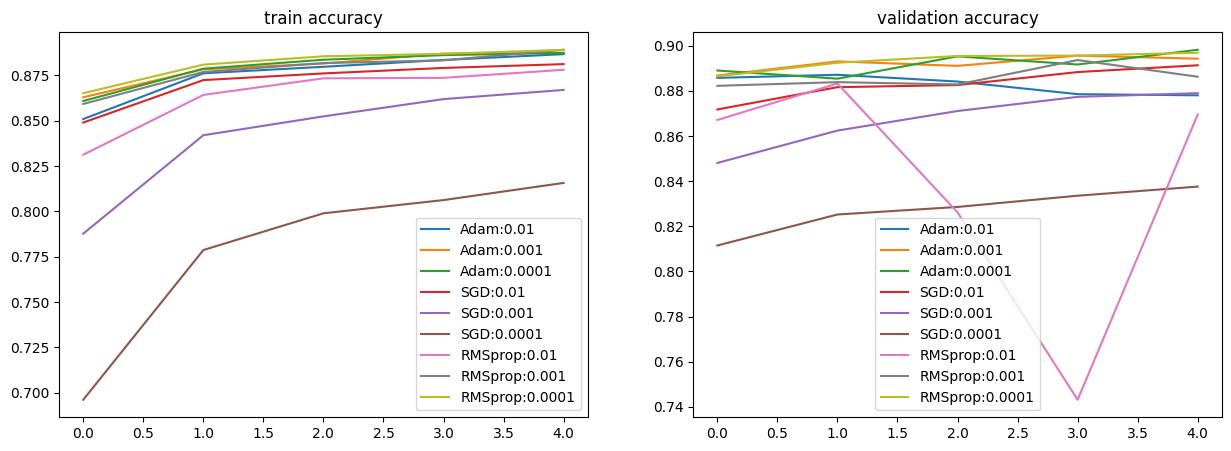

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('train accuracy')
for idx in range(len(History['accuracy'])):
  plt.plot(History['accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
  plt.legend()

plt.subplot(122)
plt.title('validation accuracy')
for idx in range(len(History['val_accuracy'])):
  plt.plot(History['val_accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
  plt.legend()

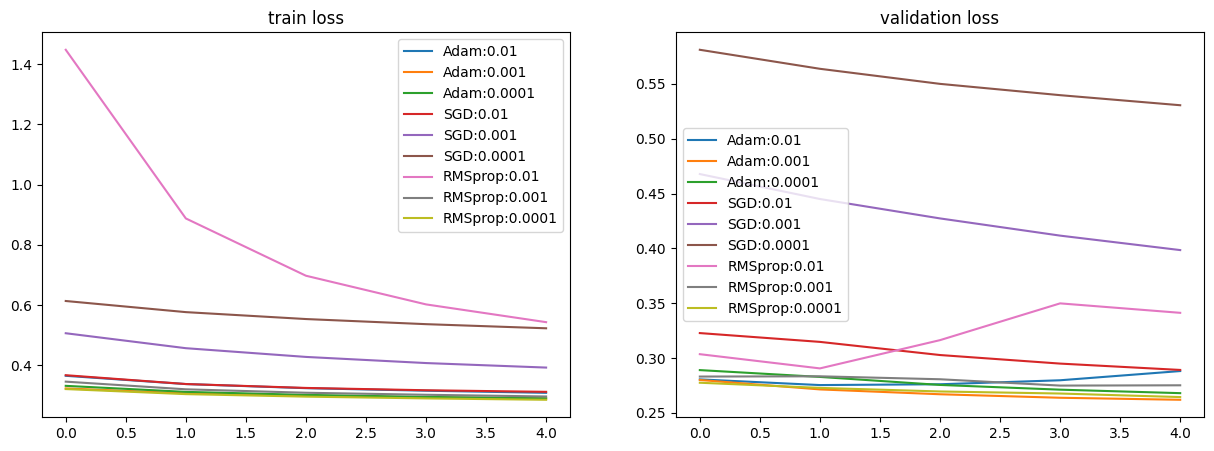

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('train loss')
for idx in range(len(History['loss'])):
  plt.plot(History['loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
  plt.legend()

plt.subplot(122)
plt.title('validation loss')
for idx in range(len(History['val_loss'])):
  plt.plot(History['val_loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
  plt.legend()

## Adam

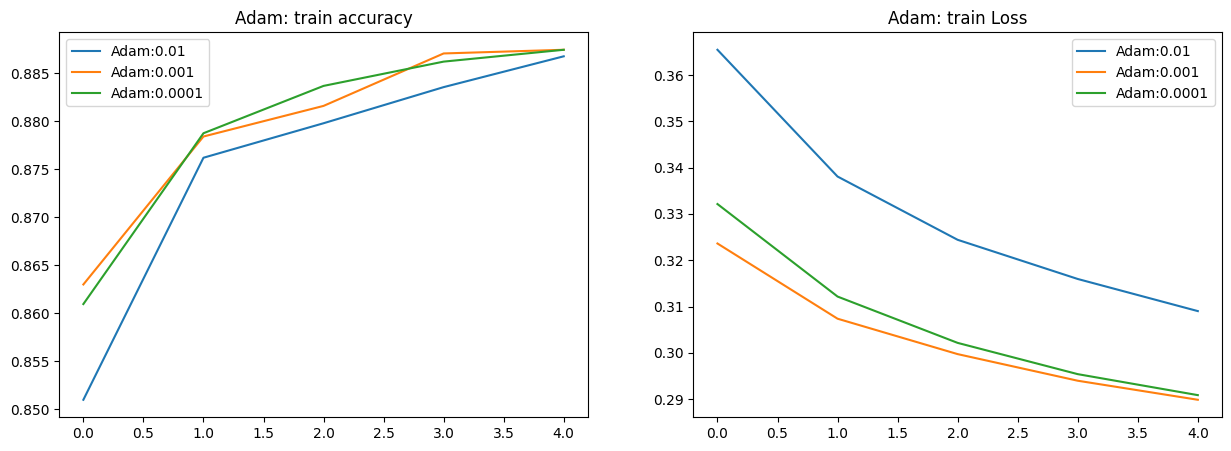

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Adam: train accuracy')
for idx in range(len(History['accuracy'])):
  if History['label_optimizer'][idx]=='Adam':
      plt.plot(History['accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()
plt.subplot(122)
plt.title('Adam: train Loss')
for idx in range(len(History['loss'])):
  if History['label_optimizer'][idx]=='Adam':
      plt.plot(History['loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()

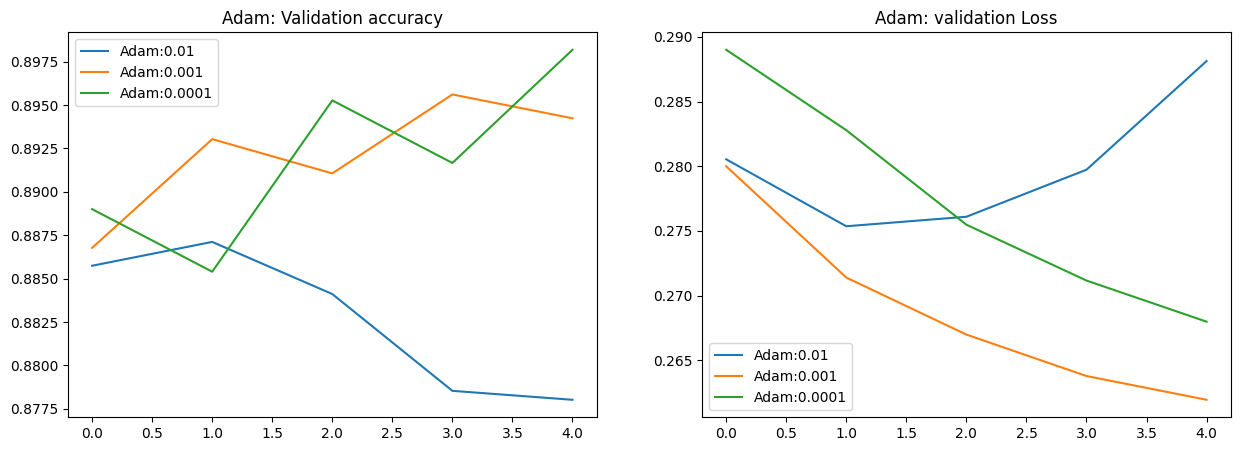

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Adam: Validation accuracy')
for idx in range(len(History['accuracy'])):
  if History['label_optimizer'][idx]=='Adam':
      plt.plot(History['val_accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()
plt.subplot(122)
plt.title('Adam: validation Loss')
for idx in range(len(History['loss'])):
  if History['label_optimizer'][idx]=='Adam':
      plt.plot(History['val_loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()

## RMSprop

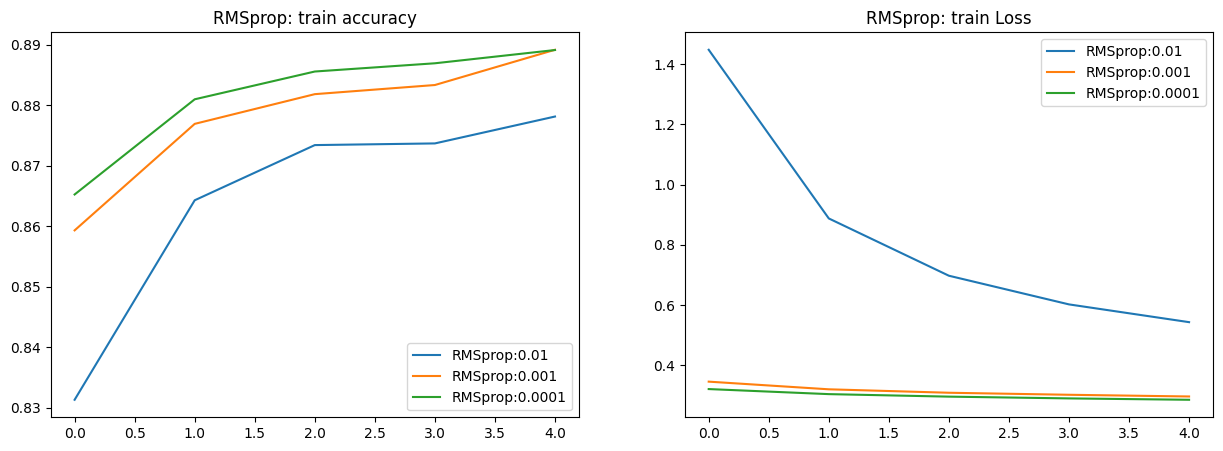

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('RMSprop: train accuracy')
for idx in range(len(History['accuracy'])):
  if History['label_optimizer'][idx]=='RMSprop':
      plt.plot(History['accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()
plt.subplot(122)
plt.title('RMSprop: train Loss')
for idx in range(len(History['loss'])):
  if History['label_optimizer'][idx]=='RMSprop':
      plt.plot(History['loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()

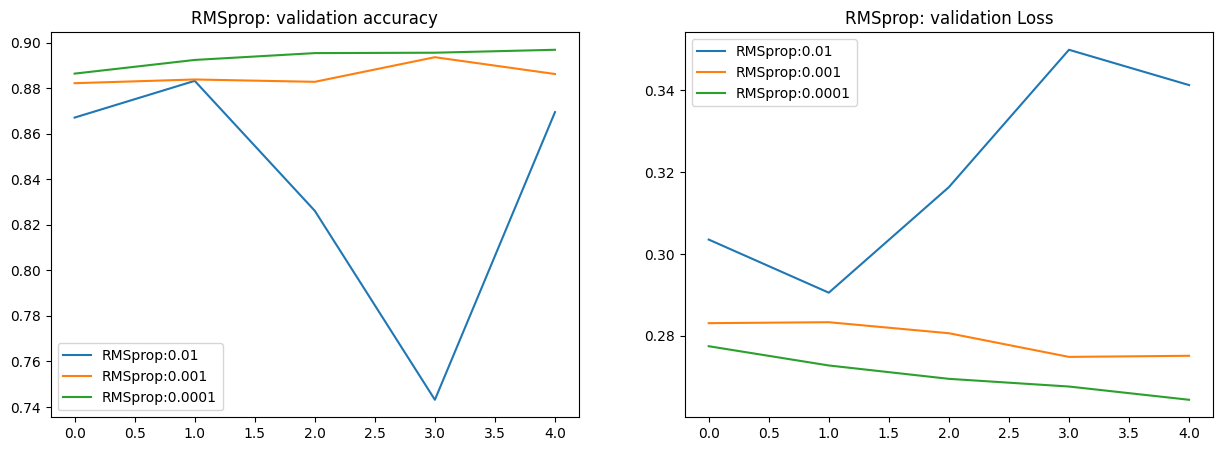

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('RMSprop: validation accuracy')
for idx in range(len(History['accuracy'])):
  if History['label_optimizer'][idx]=='RMSprop':
      plt.plot(History['val_accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()
plt.subplot(122)
plt.title('RMSprop: validation Loss')
for idx in range(len(History['loss'])):
  if History['label_optimizer'][idx]=='RMSprop':
      plt.plot(History['val_loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()

## SGD

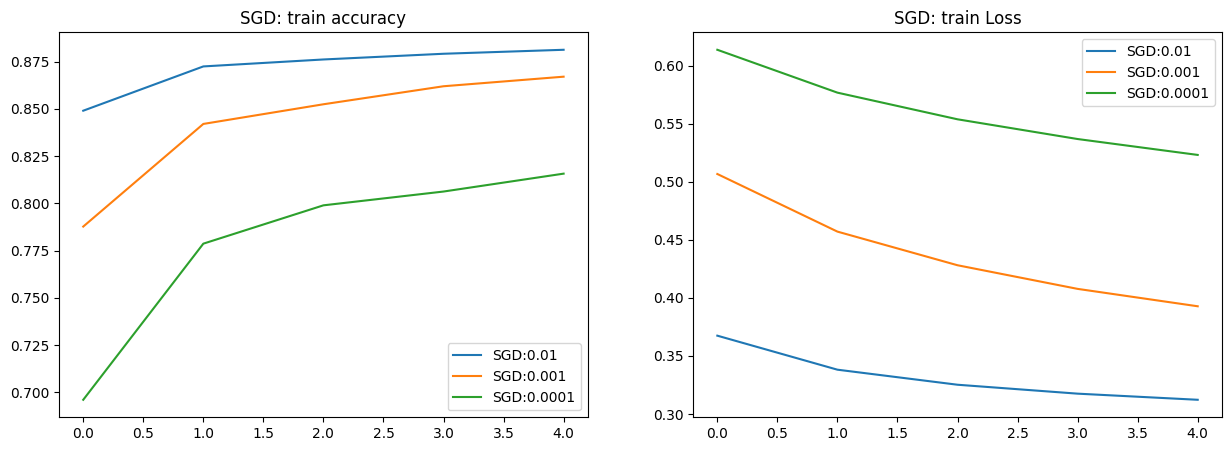

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('SGD: train accuracy')
for idx in range(len(History['accuracy'])):
  if History['label_optimizer'][idx]=='SGD':
      plt.plot(History['accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()
plt.subplot(122)
plt.title('SGD: train Loss')
for idx in range(len(History['loss'])):
  if History['label_optimizer'][idx]=='SGD':
      plt.plot(History['loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()

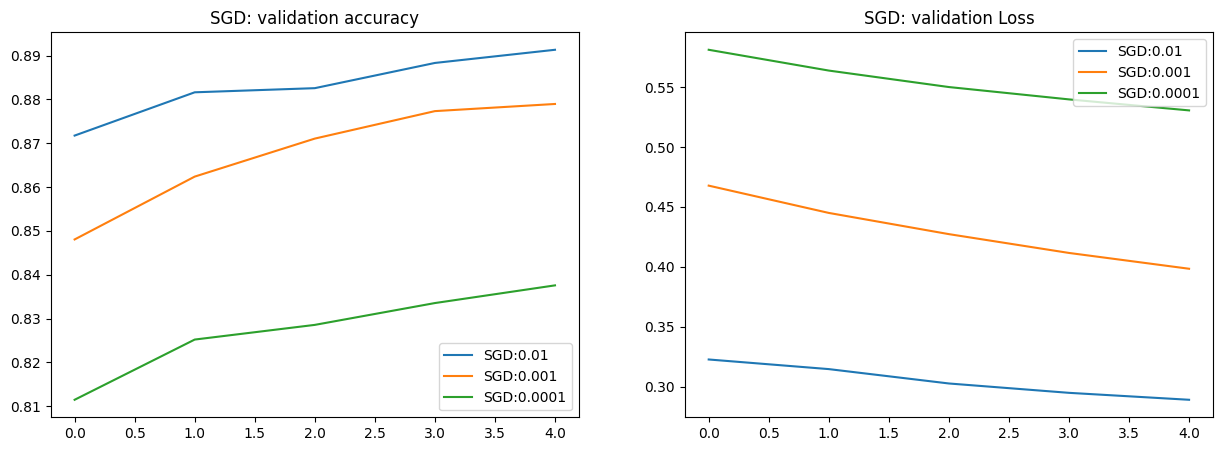

In [ ]:

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('SGD: validation accuracy')
for idx in range(len(History['accuracy'])):
  if History['label_optimizer'][idx]=='SGD':
      plt.plot(History['val_accuracy'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()
plt.subplot(122)
plt.title('SGD: validation Loss')
for idx in range(len(History['loss'])):
  if History['label_optimizer'][idx]=='SGD':
      plt.plot(History['val_loss'][idx],label=History['label_optimizer'][idx]+':'+ History['label_lr'][idx])
      plt.legend()